In [ ]:
!python3 -m pip install -Uqq openpyxl fastai duckduckgo_search

#When to Automate Things + Data Management


##Automating Tasks

It's a good idea to automate:


*   Any task that is repetitive
*   One-off tasks that are tedious, difficult, or impossible to do with existing tools

When is automation possible?

If you can come up with the steps to solve a certain problem, and the steps do not include an element of subjectivity, it is probably possible to automate it.


##Can this task be automated?

**Classification and Labeling of Data**

**POSSIBLE TASKS**

**Task**: You're given a file with 300 unlabeled screenshots that need to be renamed sorted into folders based on the social media platform its a screenshot of.


**Task**: Every day, around 10 survey submissions are received, and the responses must be placed into an existing spreadsheet, with missing cells highlighted yellow.

**TASKS THAT ARE NOT POSSIBLE**

**Task**: Go through a spreadsheet of survey responses and remove the ones that have offensive language.

Reason: 'Offensive langauge' is subjective so the task can't be automated. However, you could remove responses based on the presence of specific key words.

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

learn = load_learner('./drive/MyDrive/colab_data/export.pkl')

In [ ]:
urls = search_images('drinking water', max_images=1)
urls[0]
dest1 = 'no_alc.jpg'
download_url(urls[0], dest1, show_progress=False)

is_alc,_,probs = learn.predict(PILImage.create(dest1))
print(f"This is person is drinking alcohol." if is_alc == "alcohol" else "This person is not drinking alcohol")
print(f"Probability: {probs[0 if probs[0] > probs[1] else 1]:.4f}")

im = Image.open(dest1)
im.to_thumb(256,256)

Searching for 'drinking water'


This person is not drinking alcohol
Probability: 0.9991


OSError: ignored

<PIL.Image.Image image mode=CMYK size=256x240>

Searching for 'person drinking beer'


This is person is drinking alcohol.
Probability: 1.0000


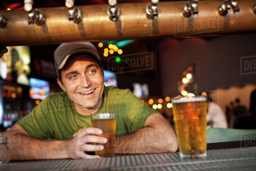

In [ ]:
urls = search_images('person drinking beer', max_images=1)
urls[0]
dest2 = 'alc.jpg'
download_url(urls[0], dest2, show_progress=False)

is_alc,_,probs = learn.predict(PILImage.create(dest2))
print(f"This is person is drinking alcohol." if (is_alc == "alchohol") else "This person is not drinking alcohol")
print(f"Probability: {probs[0 if probs[0] > probs[1] else 1]:.4f}")

im = Image.open(dest2)
im.to_thumb(256,256)

**Data Collection/Retrieval + Tasks on the internet**

APIs and libraries allow for easy data retrieval and completion of tasks that require using an internet browser/going on the internet.

**POSSIBLE TASKS**

**Task**: Given the links of 100 instagram posts, get the captions and all the comments of each post and put the data in a spreadsheet.

**Task**: Given a list of 50 email addresses, send an email addressing the person by name, and fill the body with a message that corresponds with their completion status of a survey.

**TASKS THAT ARE NOT POSSIBLE**

**Task**: Look for songs that mention drinking alcohol and compile the artist names, song titles, and lyrics in a spreadsheet.

Reason: No website to go to, looking through every single artist in a database would take a long time, too many phrases can refer to drinking alcohol

Better: Using Genius.com, get every song by a specific singer that mentions the word 'beer' 

**Task**: Take a list of citations and download their PDF version

Reason: Paywalls, may need to use multiple databases, would have to run on your personal computer

In [ ]:
import requests
from pprint import pprint
token = 'Z9Kh-RKR-r_tKwCExvcwMioWZhX7bwOMsV_OH9pDkVhwVKQfz6TYirAK1NiTwvcp'
response = requests.get('https://api.genius.com/artists/16775', headers={"Authorization" : f'Bearer {token}'})

info = response.json()['response']['artist']
print(f"{info['name']}'s Instagram handle is {info['instagram_name']}")

Sia's Instagram handle is siamusic


**Data Manipulation**

Sometimes you need have a problem that can't be solved by Excel formulas or other programs

In [ ]:
from openpyxl import load_workbook

# Load Excel sheet from file path
wb = load_workbook(filename='drive/MyDrive/colab_data/c2db2.xlsx')
sheet = wb.active

#DGIH
ID = input("Enter ID Column Letter: ")
t = input("Enter Time Column Letter: ")
eo = input("Enter EMAOccasion Column Letter: ")
ec = input("Enter EMACompliance Letter: ")

Enter ID Column Letter: D
Enter Time Column Letter: G
Enter EMAOccasion Column Letter: I
Enter EMACompliance Letter: H


In [ ]:
i, j = 2, 2
while sheet[f"{eo}{i}"].value is not None:
    # Skip row if EMAOccasion is 0 or EMACompliance is already calculated
    occ_i = (sheet[f"{ID}{i}"].value, sheet[f"{eo}{i}"].value)
    done = sheet[f"{ec}{i}"].value
    if not occ_i[1] or occ_i[1] == 0 or done is not None:
        i += 1
        j += 1
        continue

    # Get window of rows that have same ID and EMAOccasion
    occ_j = (sheet[f"{ID}{j}"].value, sheet[f"{eo}{j}"].value)
    while occ_i == occ_j:
        j += 1
        occ_j = (sheet[f"{ID}{j}"].value, sheet[f"{eo}{j}"].value)

    # Add Time values in window to set (only accepts unique values)
    nums = sheet[f"{eo}{i}"].value.split('-')
    s = set()
    for x in range(i, j):
        if sheet[f"{t}{x}"].value:
            if sheet[f"{t}{x}"].value in range(int(nums[0]), int(nums[1]) + 1):
                s.add(sheet[f"{t}{x}"].value)

    # Set compliance based on how many unique Time values there were (e.g., 0-> 0, 1-> 0.25, 2->0.5, 3->0.75, 4->1)
    comp = 0
    if len(s) == 1:
        comp = 0.25
    elif len(s) == 2:
        comp = 0.5
    elif len(s) == 3:
        comp = 0.75
    elif len(s) >= 4:
        comp = 1

    # Update compliance values
    for x in range(i, j):
        _cell = sheet.cell(x, 21)
        sheet[f"{ec}{x}"] = None
        _cell.number_format = 'Number'
        sheet[f"{ec}{x}"] = comp

    # Move on to next window
    i = j

# Save file
wb.save(filename="c2db2_filled.xlsx")

## Data Management

The two main things to consider when working with data are **consistency** and **edge cases**.

**Consistency**

* Making sure sheet format remains consistent (e.g., column headers are in the exact same order, separators are the same, etc.)
* Making sure the data types in each column remain the same between sheets

**Edge cases**

Edge cases are points of data that differ from of the normal occurence of data.

Example: Highlight rows of a spreadsheet based on yearly income. Highlight incomes between 0-100k blue, 100k-1M red, and 1M+ yellow. 

**Outlier**: Someone in the sheet makes 1B a year, someone makes 0 dollars a year

**Edge Case**: Someone makes exactly 100k a year, some incomes are in Euros, etc.

Knowing what edge cases may exist in your data is important because it may affect how we carry out the task. 
